In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
print(os.cpu_count())

import copy
import wandb
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from torch import nn
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
import torch.backends.cudnn as cudnn

from torcheval.metrics.functional import binary_auroc

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedGroupKFold

import albumentations as A
from albumentations.pytorch import ToTensorV2

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

cudnn.benchmark = True
torch.set_float32_matmul_precision('high')

30


Using cuda device


In [3]:

# train_metadata_df = pd.read_csv("../data/train-metadata.csv")
# print(len(train_metadata_df))

# gkf = StratifiedGroupKFold(n_splits=5) # , shuffle=True, random_state=42

# train_metadata_df["fold"] = -1
# for idx, (train_idx, val_idx) in enumerate(gkf.split(train_metadata_df, train_metadata_df["target"], groups=train_metadata_df["patient_id"])):
#     train_metadata_df.loc[val_idx, "fold"] = idx

train_metadata_df = pd.read_csv("../data/stratified_5_fold_train_metadata.csv")

print(train_metadata_df.loc[train_metadata_df.fold == 0].target.value_counts())
print(train_metadata_df.loc[train_metadata_df.fold == 1].target.value_counts())
print(train_metadata_df.loc[train_metadata_df.fold == 2].target.value_counts())
print(train_metadata_df.loc[train_metadata_df.fold == 3].target.value_counts())
print(train_metadata_df.loc[train_metadata_df.fold == 4].target.value_counts())

/tmp/ipykernel_1098766/1021984421.py:10: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_metadata_df = pd.read_csv("../data/stratified_5_fold_train_metadata.csv")


target
0    80134
1       77
Name: count, dtype: int64
target
0    80133
1       83
Name: count, dtype: int64
target
0    80133
1       78
Name: count, dtype: int64
target
0    80133
1       78
Name: count, dtype: int64
target
0    80133
1       77
Name: count, dtype: int64


## Dataloader

In [4]:
def add_path(row):
    return f"../data/train-image/image/{row.isic_id}.jpg"

train_metadata_df["path"] = train_metadata_df.apply(lambda row: add_path(row), axis=1)

In [5]:
class SkinDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None, target_transform=None):
        assert "path" in df.columns
        assert "target" in df.columns

        self.paths = df.path.tolist()
        self.labels = df.target.tolist() # binary
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx: int):
        image = read_image(self.paths[idx]).to(torch.float32) / 255.0
        label = self.labels[idx] / 1.0
        if self.transform:
            image = image.numpy().transpose((1,2,0))
            image = self.transform(image=image)["image"]
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

    def get_class_samples(self, class_label):
        indices = [i for i, label in enumerate(self.labels) if label == class_label]
        return indices

In [6]:
data_transforms = {
    "train": A.Compose(
        [
            A.Resize(224, 224),
            A.RandomRotate90(p=0.5),
            A.Flip(p=0.5),
            A.Downscale(p=0.25),
            A.ShiftScaleRotate(
                shift_limit=0.1, scale_limit=0.15, rotate_limit=60, p=0.5
            ),
            A.HueSaturationValue(
                hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5
            ),
            A.RandomBrightnessContrast(
                brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5
            ),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0,
            ),
            ToTensorV2(),
        ],
        p=1.0,
    ),
    "valid": A.Compose(
        [
            A.Resize(224, 224),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0,
            ),
            ToTensorV2(),
        ],
        p=1.0,
    ),
}

In [7]:
train_df = train_metadata_df.loc[train_metadata_df.fold == 0] # using a subset for training
valid_df = train_metadata_df.loc[train_metadata_df.fold == 1] # using another fold for validation

num_workers = 24 # based on profiling

train_dataset = SkinDataset(train_df, transform=data_transforms["train"])
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=num_workers, pin_memory=True, persistent_workers=True, drop_last=True)

valid_dataset = SkinDataset(valid_df, transform=data_transforms["valid"])
valid_dataloader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True, drop_last=True)

dataset_sizes = {"train": len(train_dataset), "val": len(valid_dataset)}
dataset_sizes

{'train': 80211, 'val': 80216}

### Investigating the Dataloader more

doing on the full dataset

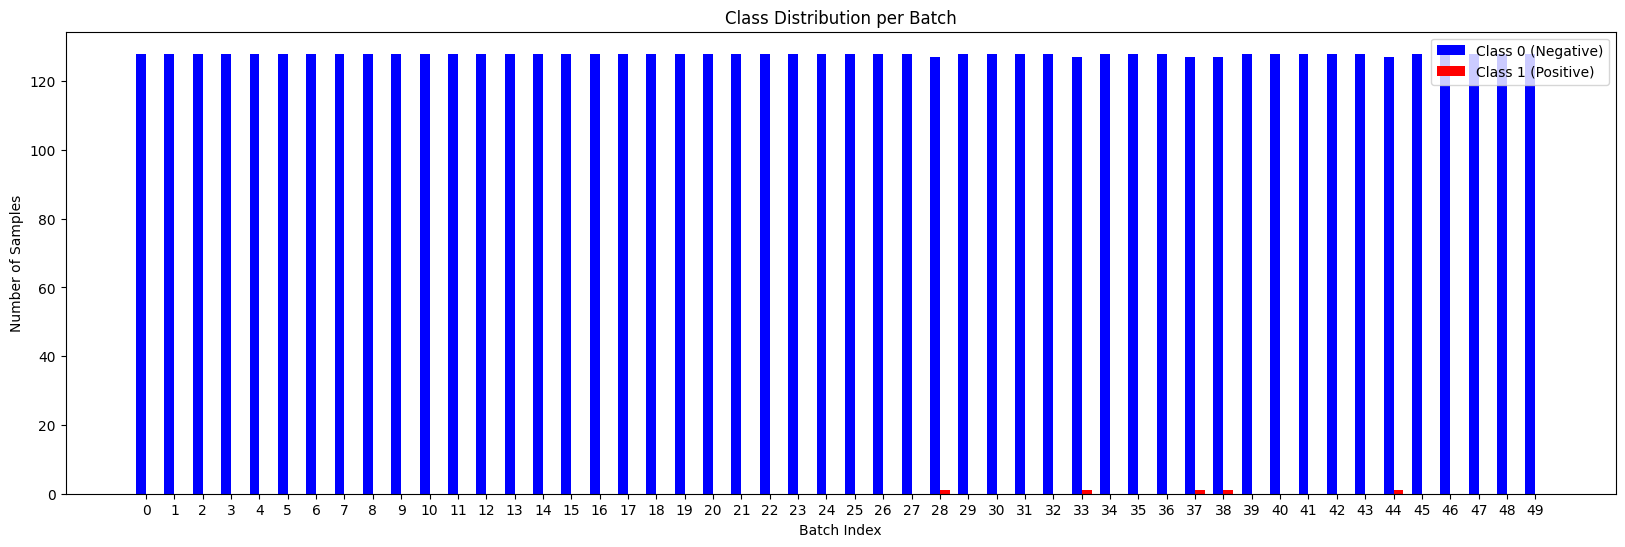

In [8]:
import torch
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# Lists to store the counts of each class per batch
batch_class_counts_0 = []
batch_class_counts_1 = []

# Iterate over the dataloader
for batch_idx, (data, labels) in enumerate(train_dataloader):
    class_0_count = (labels == 0).sum().item()
    class_1_count = (labels == 1).sum().item()
    batch_class_counts_0.append(class_0_count)
    batch_class_counts_1.append(class_1_count)

# Plot the distribution using bar chart
batch_indices = range(len(batch_class_counts_0[:50]))
width = 0.35  # width of the bars

plt.figure(figsize=(20, 6))
plt.bar(batch_indices, batch_class_counts_0[:50], width, label='Class 0 (Negative)', color='b')
plt.bar([i + width for i in batch_indices], batch_class_counts_1[:50], width, label='Class 1 (Positive)', color='r')

plt.xlabel('Batch Index')
plt.ylabel('Number of Samples')
plt.title('Class Distribution per Batch')
plt.legend()
plt.xticks([i + width / 2 for i in batch_indices], batch_indices)
plt.show()

In [9]:
neg_samples = len(train_dataloader.dataset.get_class_samples(0))
pos_samples = len(train_dataloader.dataset.get_class_samples(1))
print(neg_samples, pos_samples)

neg_wts = 1 / neg_samples
pos_wts = 1 / pos_samples
print(neg_wts, pos_wts)

80134 77
1.2479097511667955e-05 0.012987012987012988


In [10]:
sample_wts = []

for label in train_dataset.labels:
    if label == 0:
        sample_wts.append(neg_wts)
    else:
        sample_wts.append(pos_wts)

len(sample_wts)

80211

In [11]:
from torch.utils.data import WeightedRandomSampler

sampler = WeightedRandomSampler(weights=sample_wts, num_samples=len(train_dataset), replacement=True)
wt_train_dataloader = DataLoader(
    train_dataset, sampler=sampler, batch_size=128, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True, drop_last=True
)

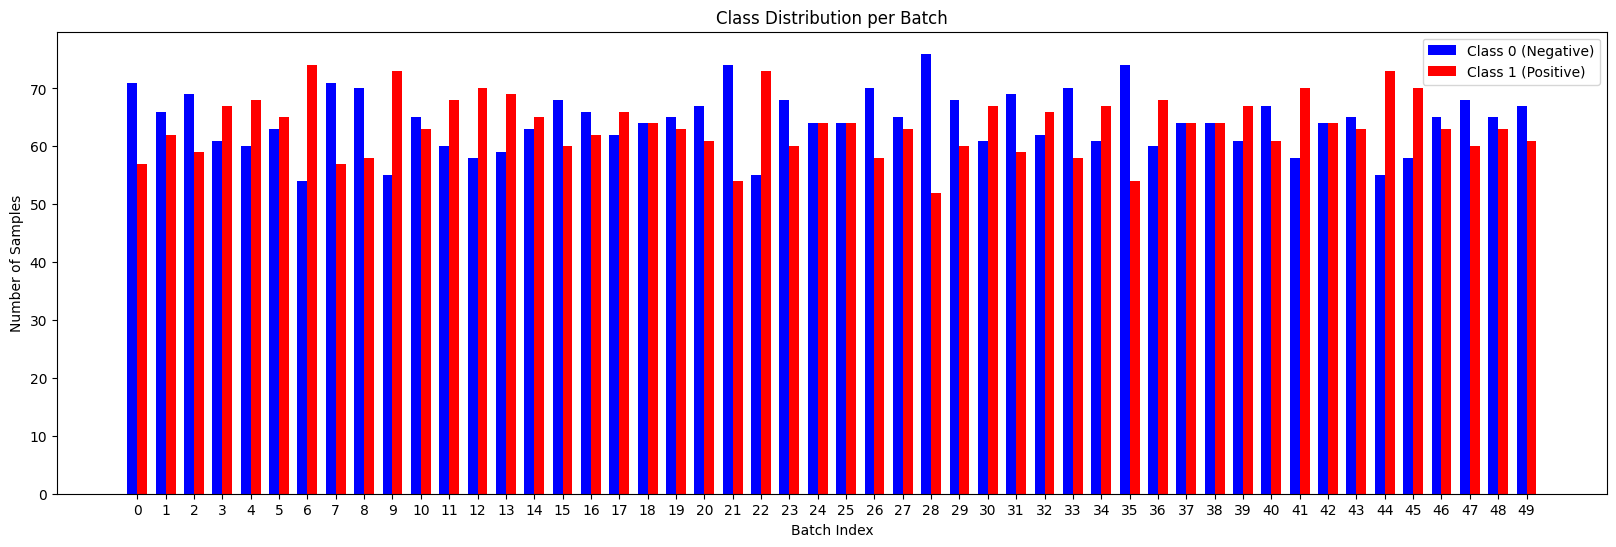

In [12]:
import torch
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# Lists to store the counts of each class per batch
wt_batch_class_counts_0 = []
wt_batch_class_counts_1 = []

# Iterate over the dataloader
for batch_idx, (data, labels) in enumerate(wt_train_dataloader):
    class_0_count = (labels == 0).sum().item()
    class_1_count = (labels == 1).sum().item()
    wt_batch_class_counts_0.append(class_0_count)
    wt_batch_class_counts_1.append(class_1_count)

# Plot the distribution using bar chart
batch_indices = range(len(wt_batch_class_counts_0[:50]))
width = 0.35  # width of the bars

plt.figure(figsize=(20, 6))
plt.bar(batch_indices, wt_batch_class_counts_0[:50], width, label='Class 0 (Negative)', color='b')
plt.bar([i + width for i in batch_indices], wt_batch_class_counts_1[:50], width, label='Class 1 (Positive)', color='r')

plt.xlabel('Batch Index')
plt.ylabel('Number of Samples')
plt.title('Class Distribution per Batch')
plt.legend()
plt.xticks([i + width / 2 for i in batch_indices], batch_indices)
plt.show()

> highly imbalanced - most batches will not see any positive image; need special handling.

### Let's visualize the positive samples.

In [ ]:
# from torch.utils.data import Subset


# pos_sample_indices = dataset.get_class_samples(1)
# print("Number of positive samples: ", len(pos_sample_indices))

# pos_subset_dataset = Subset(dataset, pos_sample_indices)

# run = wandb.init(project="isic_lesions_24")

# pos_table = wandb.Table(columns=["image", "label"])
# for img, label in iter(pos_subset_dataset):
#     img = img.numpy().transpose((1, 2, 0))
#     pos_table.add_data(
#         wandb.Image(img),
#         label,
#     )

# run.log({"AlL Positive Skin Cancer Samples": pos_table})

# run.finish()

## Model

In [8]:
model_ft = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
model_ft.classifier[2] = nn.Linear(model_ft.classifier[2].in_features, 1, bias=False)

model_ft = model_ft.to(device)
model_ft = torch.compile(model_ft)
model_ft

OptimizedModule(
  (_orig_mod): ConvNeXt(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=96, out_features=384, bias=True)
            (4): GELU(approximate='none')
            (5): Linear(in_features=384, out_features=96, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm

In [9]:
# criterion = nn.BCEWithLogitsLoss()
# optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001, weight_decay=1e-6)


from libauc.losses import AUCMLoss
from libauc.optimizers import PESG

criterion = AUCMLoss()
optimizer_ft = PESG(
    model_ft.parameters(),
    loss_fn=criterion,
    lr=0.001, 
    weight_decay=1e-5,
    mode="sgd",
)

In [10]:
def train_model(model, dataloader, criterion, optimizer, scheduler=None):
    model.train()  # Set model to training mode

    running_loss = 0.0
    running_auroc = 0.0
    batch_loss = []

    for idx, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device).flatten()

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs).flatten()
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

        loss_val = loss.detach()
        batch_loss.append(loss_val)
        running_loss += loss_val * inputs.size(0)

        auroc = binary_auroc(input=outputs, target=labels).item()
        running_auroc += auroc * inputs.size(0)

        if (idx + 1) % 100 == 0:
            wandb.log({"train_loss": loss_val, "train_auroc": auroc})
            print(f"Train Batch Loss: {loss_val} | Train AUROC: {auroc}")

    epoch_loss = running_loss / dataset_sizes["train"]
    epoch_auroc = running_auroc / dataset_sizes["train"]

    return model, epoch_loss, epoch_auroc, batch_loss


def validate_model(model, dataloader, criterion, optimizer):
    model.eval()

    running_loss = 0.0
    running_auroc = 0.0
    batch_loss = []

    for idx, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device).flatten()

        optimizer.zero_grad()

        with torch.no_grad():
            outputs = model(inputs).flatten()
            loss = criterion(outputs, labels)

        loss_val = loss.detach()
        batch_loss.append(loss_val)
        running_loss += loss_val * inputs.size(0)

        auroc = binary_auroc(input=outputs, target=labels).item()
        running_auroc += auroc * inputs.size(0)

        if (idx + 1) % 100 == 0:
            wandb.log({"valid_loss": loss_val, "valid_auroc": auroc})
            print(f"valid Batch Loss: {loss_val} | Valid AUROC: {auroc}")

    valid_loss = running_loss / dataset_sizes["val"]
    valid_auroc = running_auroc / dataset_sizes["val"]

    return model, valid_loss, valid_auroc, batch_loss

In [11]:
run = wandb.init(project="isic_lesions_24", job_type="train")

best_epoch_auroc = -np.inf
best_valid_loss = np.inf
early_stopping_patience = 4
epochs_no_improve = 0

for epoch in range(10):
    model_ft, epoch_loss, train_auroc, train_batch_losses = train_model(model_ft, train_dataloader, criterion, optimizer_ft)
    model_ft, valid_loss, valid_auroc, valid_batch_losses = validate_model(model_ft, valid_dataloader, criterion, optimizer_ft)

    print(f"Epoch: {epoch} | Train Loss: {epoch_loss} | Train AUROC: {train_auroc} | Valid Loss: {valid_loss} | Valid AUROC: {valid_auroc} \n")
    wandb.log({
        "epoch": epoch,
        "epoch_loss": epoch_loss,
        "epoch_val_loss": valid_loss,
        "epoch_train_auroc": train_auroc,
        "epoch_valid_auroc": valid_auroc,
    })

    if best_epoch_auroc <= valid_auroc:
        print(f"Validation AUROC Improved ({best_epoch_auroc} ---> {valid_auroc})")
        best_epoch_auroc = valid_auroc
        best_model_wts = copy.deepcopy(model_ft.state_dict())
        PATH = "../models/AUROC{:.4f}_Loss{:.4f}_epoch{:.0f}.bin".format(valid_auroc, valid_loss.item(), epoch)
        torch.save(model_ft.state_dict(), PATH)
        # Save a model file from the current directory
        print(f"Model Saved")

    if best_valid_loss >= valid_loss:
        best_valid_loss = valid_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        print(f"Early stopping triggered after {epochs_no_improve} epochs with no improvement.")
        break

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: ayush-thakur. Use `wandb login --relogin` to force relogin


/home/ubuntu/.local/lib/python3.10/site-packages/libauc/losses/auc.py:111: UserWarning: Input data has no positive sample! Please use 'libauc.sampler.DualSampler' for data resampling!
  warnings.warn("Input data has no positive sample! Please use 'libauc.sampler.DualSampler' for data resampling!", UserWarning)
/home/ubuntu/.local/lib/python3.10/site-packages/libauc/losses/auc.py:111: UserWarning: Input data has no positive sample! Please use 'libauc.sampler.DualSampler' for data resampling!
  warnings.warn("Input data has no positive sample! Please use 'libauc.sampler.DualSampler' for data resampling!", UserWarning)


Train Batch Loss: tensor([0.], device='cuda:0') | Train AUROC: 0.5
Train Batch Loss: tensor([0.], device='cuda:0') | Train AUROC: 0.5
Train Batch Loss: tensor([0.], device='cuda:0') | Train AUROC: 0.5
Train Batch Loss: tensor([0.], device='cuda:0') | Train AUROC: 0.5
Train Batch Loss: tensor([0.], device='cuda:0') | Train AUROC: 0.5
Train Batch Loss: tensor([0.0076], device='cuda:0') | Train AUROC: 0.047244094488188976


/home/ubuntu/.local/lib/python3.10/site-packages/libauc/losses/auc.py:111: UserWarning: Input data has no positive sample! Please use 'libauc.sampler.DualSampler' for data resampling!
  warnings.warn("Input data has no positive sample! Please use 'libauc.sampler.DualSampler' for data resampling!", UserWarning)


valid Batch Loss: tensor([0.0071], device='cuda:0') | Valid AUROC: 0.41732283464566927
valid Batch Loss: tensor([0.], device='cuda:0') | Valid AUROC: 0.5
valid Batch Loss: tensor([0.], device='cuda:0') | Valid AUROC: 0.5
valid Batch Loss: tensor([0.], device='cuda:0') | Valid AUROC: 0.5
valid Batch Loss: tensor([0.], device='cuda:0') | Valid AUROC: 0.5
valid Batch Loss: tensor([0.], device='cuda:0') | Valid AUROC: 0.5
Epoch: 0 | Train Loss: tensor([0.0006], device='cuda:0') | Train AUROC: 0.49075138749744013 | Valid Loss: tensor([0.0009], device='cuda:0') | Valid AUROC: 0.4861394918634073 

Validation AUROC Improved (-inf ---> 0.4861394918634073)
Model Saved
Train Batch Loss: tensor([0.], device='cuda:0') | Train AUROC: 0.5


KeyboardInterrupt: 

In [ ]:
model_ft.load_state_dict(best_model_wts)

In [64]:
@torch.inference_mode()
def infer_model(model, dataloader):
    model.eval()

    preds = []
    gts = []

    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device).flatten()

        with torch.no_grad():
            outputs = model(inputs).flatten()
            preds.extend(torch.sigmoid(outputs))
            gts.extend(labels)

    preds = [pred.item() for pred in preds]
    gts = [gt.item() for gt in gts]

    return preds, gts

In [65]:
def comp_score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float=0.80):
    v_gt = abs(np.asarray(solution.values)-1)
    v_pred = np.array([1.0 - x for x in submission.values])
    max_fpr = abs(1-min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
    # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    return partial_auc

preds, gts = infer_model(model_ft, valid_dataloader)

comp_score(
    pd.DataFrame(gts, columns=["target"]),
    pd.DataFrame(preds, columns=["prediction"]),
    ""
)

100%|██████████| 626/626 [03:05<00:00,  3.37it/s]  


0.03660723213851316

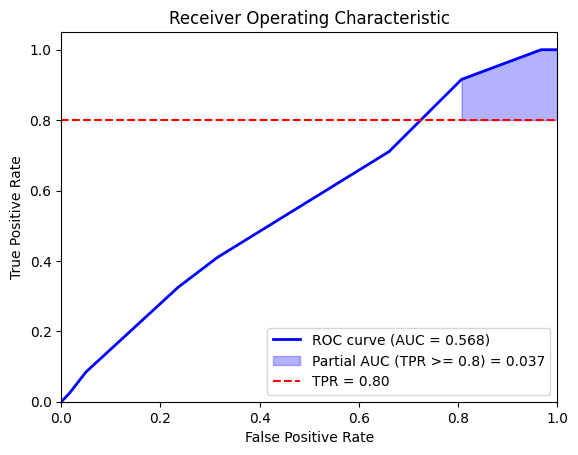

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

def comp_score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float=0.80):
    v_gt = abs(np.asarray(solution.values) - 1)
    v_pred = np.array([1.0 - x for x in submission.values])
    max_fpr = abs(1 - min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    # Change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    return partial_auc

tpr_threshold = 0.8

# Generate example data
y_true = gts
y_scores = preds

# Convert to DataFrame as expected by comp_score function
solution = pd.DataFrame(y_true, columns=['label'])
submission = pd.DataFrame(y_scores, columns=['score'])

# Calculate the partial AUC using the competition's scoring function
pAUC_comp = comp_score(solution, submission, row_id_column_name="", min_tpr=0.80)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.3f)' % roc_auc)

# Shade the area where TPR >= 80%
start_idx = np.where(tpr >= tpr_threshold)[0][0]
fpr_shade = np.concatenate(([fpr[start_idx]], fpr[start_idx:], [1]))
tpr_shade = np.concatenate(([tpr_threshold], tpr[start_idx:], [tpr_threshold]))
plt.fill_between(fpr_shade, tpr_shade, y2=0.8, alpha=0.3, color='blue', label='Partial AUC (TPR >= 0.8) = %0.3f' % pAUC_comp)

# Add dashed line for TPR threshold
plt.axhline(y=tpr_threshold, color='red', linestyle='--', label='TPR = 0.80')

# Add labels and legend
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()